<a href="https://colab.research.google.com/github/ai-fast-track/timeseries/blob/master/nbs/univariate_timeseries_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train univariate time series
> A tutorial that can be run in Google Colab or on a local machine

In [ ]:
# Run this cell to install the latest version of fastcore shared on github
!pip install git+https://github.com/fastai/fastai.git

In [ ]:
# Run this cell to install the latest version of fastcore shared on github
!pip install git+https://github.com/fastai/fastcore.git

In [ ]:
# Run this cell to install the latest version of timeseries shared on github
!pip install git+https://github.com/ai-fast-track/timeseries.git

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [ ]:
from fastai.basics import *

In [ ]:
# hide
# Only for Windows users because symlink to `timeseries` folder is not recognized by Windows
import sys
sys.path.append("..")

In [ ]:
from timeseries.all import *

## ECG Dataset
> This dataset was formatted by R. Olszewski as part of his thesis
“Generalized feature extraction for structural	pattern recognition
in time-series data,” at Carnegie Mellon University, 2001. Each
series traces the electrical activity recorded during one
heartbeat. The two classes are a normal heartbeat and a Myocardial
Infarction. Cardiac ischemia refers to lack of blood flow and oxygen to the heart muscle. If ischemia is severe or lasts too long, it can cause a heart attack (myocardial infarction) and can lead to heart tissue death. 	

![](images/ECG200.png)

In [ ]:
dsname =  'ECG200' # 'ChlorineConcentration', 'Yoga', ECG_200

In [ ]:
# url = 'http://www.timeseriesclassification.com/Downloads/Yoga.zip'
path = unzip_data(URLs_TS.UNI_ECG200)
path

Path('/home/farid/.fastai/data/ECG200')

In [ ]:
fname_train = f'{dsname}_TRAIN.arff'
fname_test = f'{dsname}_TEST.arff'
fnames = [path/fname_train, path/fname_test]
fnames

[Path('/home/farid/.fastai/data/ECG200/ECG200_TRAIN.arff'),
 Path('/home/farid/.fastai/data/ECG200/ECG200_TEST.arff')]

In [ ]:
data = TSData.from_arff(fnames)
print(data)

TSData:
 Datasets names (concatenated): ['ECG200_TRAIN', 'ECG200_TEST']
 Filenames:                     [Path('/home/farid/.fastai/data/ECG200/ECG200_TRAIN.arff'), Path('/home/farid/.fastai/data/ECG200/ECG200_TEST.arff')]
 Data shape: (200, 1, 96)
 Targets shape: (200,)
 Nb Samples: 200
 Nb Channels:           1
 Sequence Length: 96


In [ ]:
items = data.get_items()

In [ ]:
seed = 42
splits = RandomSplitter(seed=seed)(range_of(items)) #by default 80% for train split and 20% for valid split are chosen 
splits

((#160) [66,176,14,106,71,193,95,16,133,113...],
 (#40) [142,56,198,77,50,55,4,69,174,47...])

In [ ]:
bs = 32                            
# Normalize at batch time
tfm_norm = Normalize(scale_subtype = 'per_sample_per_channel', scale_range=(0, 1)) # per_sample , per_sample_per_channel
# tfm_norm = Standardize(scale_subtype = 'per_sample')
batch_tfms = [tfm_norm]

In [ ]:
default_device()

device(type='cpu')

In [ ]:
lbl_dict = dict([
    ('-1', 'Normal'),   
    ('1', 'Myocardial Infarction')]
)

In [ ]:
# dls = TSDataLoaders.from_files(fnames=fnames, batch_tfms=batch_tfms, num_workers=0, device=default_device())
dls = TSDataLoaders.from_files(fnames=fnames, lbl_dict=lbl_dict, num_workers=0, device=default_device())

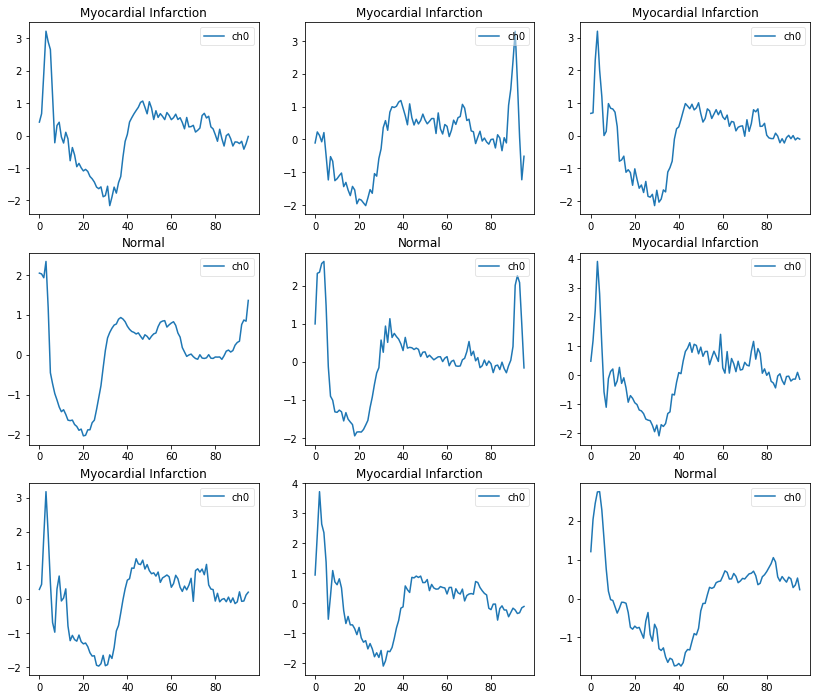

In [ ]:
dls.show_batch(max_n=9)

## Training Model

In [ ]:
# Number of channels (i.e. dimensions in ARFF and TS files jargon)
c_in = get_n_channels(dls.train) # data.n_channels
# Number of classes
c_out= dls.c 
c_in,c_out

(1, 2)

In [ ]:
model = inception_time(c_in, c_out).to(device=default_device())
model

Sequential(
  (0): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (convs): ModuleList(
          (0): Conv1d(1, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
          (1): Conv1d(1, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
          (2): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        )
        (maxpool_bottleneck): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
        (bn_relu): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
        )
      )
    )
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
        (convs): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39,), 

In [ ]:
# opt_func = partial(Adam, lr=3e-3, wd=0.01)
#Or use Ranger
def opt_func(p, lr=slice(3e-3)): return Lookahead(RAdam(p, lr=lr, mom=0.95, wd=0.01)) 

In [ ]:
#Learner
loss_func = LabelSmoothingCrossEntropy() 
learn = Learner(dls, model, opt_func=opt_func, loss_func=loss_func, metrics=accuracy)

print(learn.summary())

Sequential (Input shape: ['64 x 1 x 96'])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               64 x 32 x 96         1,248      True      
________________________________________________________________
Conv1d               64 x 32 x 96         608        True      
________________________________________________________________
Conv1d               64 x 32 x 96         288        True      
________________________________________________________________
MaxPool1d            64 x 1 x 96          0          False     
________________________________________________________________
Conv1d               64 x 32 x 96         32         True      
________________________________________________________________
BatchNorm1d          64 x 128 x 96        256        True      
________________________________________________________________
ReLU                 64 x 128 x 96        0          False     
________________________________________________________

(0.0015848932787775993, 0.00019054606673307717)

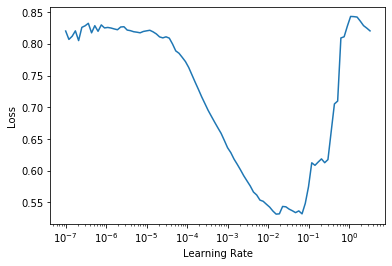

In [ ]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

In [ ]:
learn.fit_one_cycle(25, lr_max=1e-3) 

epoch,train_loss,valid_loss,accuracy,time
0,0.817841,0.693589,0.425000,00:01
1,0.785016,0.692640,0.575000,00:01
2,0.780559,0.691408,0.575000,00:01
3,0.758813,0.690536,0.575000,00:01
4,0.697321,0.689825,0.575000,00:01
5,0.638173,0.687422,0.575000,00:01
6,0.590113,0.685483,0.575000,00:01
7,0.547409,0.682268,0.575000,00:01
8,0.511193,0.678869,0.575000,00:01
9,0.480629,0.673609,0.575000,00:01


## Graphs

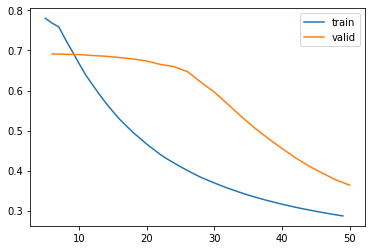

In [ ]:
learn.recorder.plot_loss()

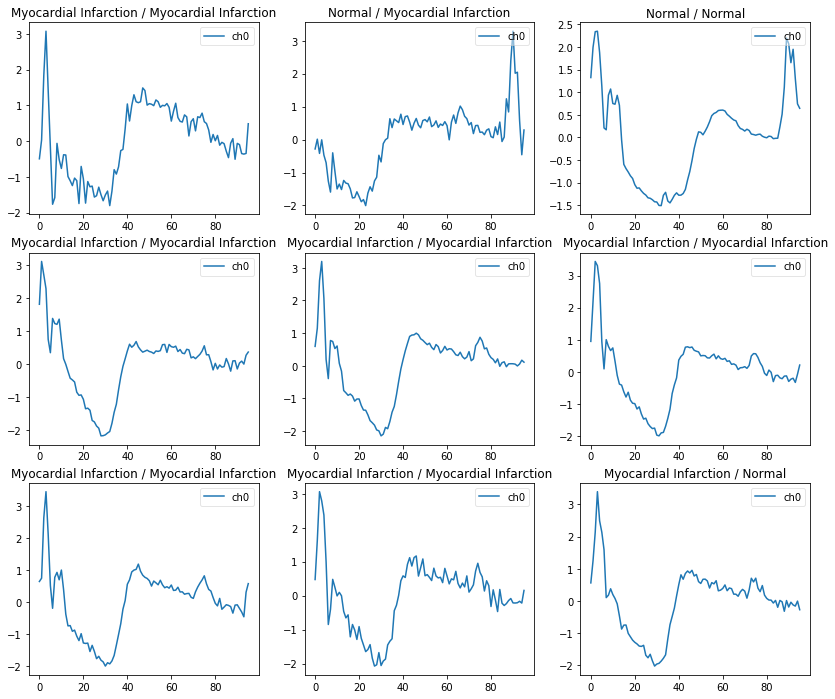

In [ ]:
learn.show_results(max_n=9)

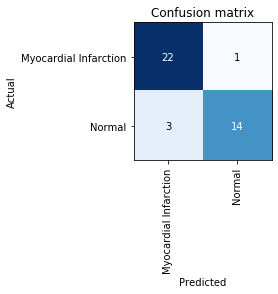

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()

[('Normal', 'Myocardial Infarction', 3),
 ('Myocardial Infarction', 'Normal', 1)]

![](images/yoga.jpg)
<a href="https://unsplash.com/@clearsky?utm_medium=referral&amp;utm_campaign=photographer-credit&amp;utm_content=creditBadge">Photo Credit: Farsai Chaikulngamdee</a>